# Librerías

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.cluster import DBSCAN
import cv2

# Funciones y Clases Generales

In [12]:
class ROISelector:
    '''
    Clase para seleccionar un ROI de una imagen.
    '''
    def __init__(self, image):
        self.image = image.copy()
        self.clone = self.image.copy()
        self.x_init, self.y_init = -1, -1
        self.roi = None

    def select_roi(self, event, x, y, flags, param):
        '''
        Método para seleccionar un ROI de una imagen.

        Parámetros:
            event (cv2 event): evento de OpenCV
            x (int): coordenada x del mouse
            y (int): coordenada y del mouse
            flags (int): flags de OpenCV
            param (any): parámetro adicional
        '''
        if event == cv2.EVENT_LBUTTONDOWN:
            self.x_init, self.y_init = x, y
        elif event == cv2.EVENT_MOUSEMOVE and flags == cv2.EVENT_FLAG_LBUTTON:
            self.image = self.clone.copy()
            cv2.rectangle(self.image, (self.x_init, self.y_init), (x, y), (255, 255, 255), 2)
        elif event == cv2.EVENT_LBUTTONUP:
            self.roi = self.clone[min(self.y_init, y):max(self.y_init, y),
                                 min(self.x_init, x):max(self.x_init, x)]
            cv2.rectangle(self.image, (self.x_init, self.y_init), (x, y), (255, 255, 255), 2)
            cv2.imshow("ROI", self.roi)

    def run(self):
        '''
        Método para ejecutar la selección del ROI.

        Retorno:
            np.array: ROI seleccionado
        '''
        cv2.namedWindow("Image")
        cv2.setMouseCallback("Image", self.select_roi)

        while True:
            cv2.imshow("Image", self.image)
            key = cv2.waitKey(1) & 0xFF

            if key == 27:
                print("Proceso terminado por el usuario.")
                break
            elif self.roi is not None and (key == 13 or key == 10):
                print("ROI seleccionada, devolviendo el array.")
                cv2.destroyAllWindows()
                return self.roi

        cv2.destroyAllWindows()
        return None

In [13]:
def convolution(image, kernel):
    '''
    Ejecuta la operación de convolución a la imagen con el kernel dado.

    Parámetros:
        image (np.array): imagen de entrada
        kernel (np.array): kernel de convolución

    Retorno:
        np.array: imagen resultante de la convolución
    '''
    # Reflejar el kernel
    kernel = np.flipud(np.fliplr(kernel))

    # Obtener las dimensiones de la imagen y el kernel
    image_h, image_w = image.shape
    kernel_h, kernel_w = kernel.shape

    # Calcular el padding para cada dimensión (alto y ancho)
    pad_h = kernel_h // 2
    pad_w = kernel_w // 2

    # Crear la imagen con padding
    padded_image = np.zeros((image_h + kernel_h - 1, image_w + kernel_w - 1))
    padded_image[pad_h:pad_h + image_h, pad_w:pad_w + image_w] = image

    # Proceso de convolución
    output = np.zeros_like(image)

    for y in range(image_h):
        for x in range(image_w):
            output[y, x] = np.sum(kernel * padded_image[y:y+kernel_h, x:x+kernel_w])

    return output

def make_square_with_padding(filtro_detector):
    '''
    Crea un filtro cuadrado con padding alrededor del filtro original.

    Parámetros:
        filtro_detector (np.array): filtro original

    Retorno:
        np.array: filtro cuadrado con padding
    '''
    # Obtener las dimensiones del filtro
    m, n = filtro_detector.shape
    
    # Determinar el tamaño del filtro cuadrado
    max_size = max(m, n)
    
    # Crear un nuevo array de ceros de tamaño cuadrado
    square_filter = np.zeros((max_size, max_size))
    
    # Colocar el filtro original en el centro del nuevo filtro cuadrado
    start_m = (max_size - m) // 2
    start_n = (max_size - n) // 2
    square_filter[start_m:start_m + m, start_n:start_n + n] = filtro_detector
    
    return square_filter

def make_square_by_cropping(filtro_detector):
    '''
    Crea un filtro cuadrado recortando el filtro original.

    Parámetros:
        filtro_detector (np.array): filtro original

    Retorno:
        np.array: filtro cuadrado recortado
    '''
    # Obtener las dimensiones del filtro
    m, n = filtro_detector.shape
    
    # Determinar el tamaño mínimo para hacer un cuadrado
    min_size = min(m, n)
    
    # Recortar para obtener un cuadrado centrado
    start_m = (m - min_size) // 2
    start_n = (n - min_size) // 2
    
    return filtro_detector[start_m:start_m + min_size, start_n:start_n + min_size]

def trim_zeros_from_edges(image):
    '''
    Elimina filas y columnas de ceros que son completamente externas sin interrumpir las figuras internas.

    Parámetros:
        image (np.array): imagen de entrada

    Retorno:
        np.array: imagen recortada
    '''
    # Identificar las filas y columnas donde hay cualquier contenido no-cero
    rows = np.any(image != 0, axis=1)
    cols = np.any(image != 0, axis=0)

    # Encontrar los índices de la primera y última fila y columna no-cero
    first_row = np.where(rows)[0][0] if np.any(rows) else 0
    last_row = np.where(rows)[0][-1] if np.any(rows) else 0
    first_col = np.where(cols)[0][0] if np.any(cols) else 0
    last_col = np.where(cols)[0][-1] if np.any(cols) else 0

    # Recortar la imagen según los índices de las filas y columnas no-cero
    trimmed_image = image[first_row:last_row+1, first_col:last_col+1]

    return trimmed_image

def filter_for_image(image, kernel, type_of_filter, delete_all_zeros = True, delete_border_zeros = False):
    '''
    Crea un filtro para una imagen con un kernel dado.

    Parámetros:
        image (np.array): imagen de entrada
        kernel (np.array): kernel de convolución
        type_of_filter (str): tipo de filtro a aplicar (square_padding, square_cropping)
        delete_all_zeros (bool): si se deben eliminar todas las filas y columnas que tienen solo 0's
        delete_border_zeros (bool): si se deben eliminar las filas y columnas de los bordes que tienen solo 0's

    Retorno:
        np.array: filtro para la imagen
    '''
    # Creación de filtro para imagen
    filtro_detector = convolution(image, kernel)

    if delete_border_zeros == True:
        # Eliminar filas y columnas de los bordes que tienen solo 0's
        filtro_detector = trim_zeros_from_edges(filtro_detector)

    if delete_all_zeros == True:
        # Eliminamos todas las filas y columnas que tienen solo 0's
        row_not_zeros = np.any(filtro_detector != 0, axis=1)
        col_not_zeros = np.any(filtro_detector != 0, axis=0)
        filtro_detector = filtro_detector[row_not_zeros][:, col_not_zeros]

    # Aplicar tipo de filtro
    if type_of_filter == 'square_padding':
        filtro_detector = make_square_with_padding(filtro_detector)
    elif type_of_filter == 'square_cropping':
        filtro_detector = make_square_by_cropping(filtro_detector)
    else:
        pass

    return filtro_detector

def non_max_suppression(detecciones, imagen, vecindad, eps, min_samples):
    '''
    Aplica el algoritmo de non-maximum suppression a las detecciones.

    Parámetros:
        detecciones (np.array): coordenadas de las detecciones
        imagen (np.array): imagen de entrada
        vecindad (int): vecindad para buscar el máximo local
        eps (float): radio de la vecindad para DBSCAN
        min_samples (int): número mínimo de muestras para DBSCAN

    Retorno:
        np.array: detecciones filtradas
        np.array: centros de las detecciones
    '''
    detecciones_filtradas = []
    mascara = np.zeros_like(imagen, dtype=bool)

    for y, x in detecciones:
        if not mascara[y, x]:
            inicio_y = max(0, y - vecindad)
            fin_y = min(imagen.shape[0], y + vecindad + 1)
            inicio_x = max(0, x - vecindad)
            fin_x = min(imagen.shape[1], x + vecindad + 1)

            sub_imagen = imagen[inicio_y:fin_y, inicio_x:fin_x]
            max_idx = np.argmax(sub_imagen)
            max_y, max_x = np.divmod(max_idx, sub_imagen.shape[1])
            max_y += inicio_y
            max_x += inicio_x

            if (max_y == y) and (max_x == x):
                detecciones_filtradas.append([x, y])
                mascara[inicio_y:fin_y, inicio_x:fin_x] = True

    detecciones_filtradas = np.array(detecciones_filtradas)

    if len(detecciones_filtradas) > 0:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(detecciones_filtradas)
        labels = dbscan.labels_
        centros = [detecciones_filtradas[labels == label].mean(axis=0) for label in np.unique(labels) if label != -1]
        return detecciones_filtradas, np.array(centros)

    return detecciones_filtradas, np.array([])

def draw_fixed_size_bounding_boxes(image, coords, box_width, box_height, box_padding=3):
    '''
    Dibuja bounding boxes de tamaño fijo alrededor de coordenadas de detección.

    Parámetros:
        image (np.array): Imagen original donde se dibujarán las bounding boxes.
        coords (np.array): coordenadas. Contiene posiciones (y, x) de detecciones.
        box_width (int): Ancho fijo de la bounding box.
        box_height (int): Alto fijo de la bounding box.
        box_padding (int): Padding adicional alrededor de la bounding box para asegurar cobertura.

    Retorno:
        np.array: Imagen con las bounding boxes dibujadas.
    '''
    # Hacemos una copia de la imagen para no modificar la original
    image_with_boxes = image.copy()

    # Calcula la mitad del ancho y alto para centrar la caja alrededor de la coordenada
    half_width = box_width // 2 + box_padding
    half_height = box_height // 2 + box_padding

    for x, y in coords:
        # Calcula las esquinas de la bounding box
        top_left = (max(x - half_width, 0), max(y - half_height, 0))  # Asegura no salir del límite de la imagen
        bottom_right = (min(x + half_width, image.shape[1] - 1), min(y + half_height, image.shape[0] - 1))

        # Dibujar el rectángulo (bounding box) en la imagen
        cv2.rectangle(image_with_boxes, top_left, bottom_right, (0, 255, 0), 2)

    return image_with_boxes

def show_image(images, titles):
    '''
    Muestra una o un conjunto de imágenes en un solo plot, destacan las dimensiones de cada imagen.

    Parámetros:
        images (np.array, list): Imagen o lista de imágenes a mostrar.
    '''
    if not isinstance(images, list):
        plot_images = [images]
        titles = [titles]

    fig, axs = plt.subplots(1, len(images), figsize = (20, 10))

    # Si solo hay una imagen, axs no es una lista, así que lo convertimos en lista para simplificar el bucle
    if len(images) == 1:
        axs = [axs]

    for i, image in enumerate(images):
        axs[i].imshow(image, cmap = 'gray')
        axs[i].set_title(titles[i])

# Detección de letra `L`

In [14]:
L_letter = np.zeros((10, 10))
L_letter[3:6, 3] = 1  # Parte vertical de la "L"
L_letter[5, 3:5] = 1  # Parte horizontal de la "L"

kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

In [15]:
filter_for_L = filter_for_image(L_letter, kernel, type_of_filter = 'square_padding')
L_founded = convolution(L_letter, filter_for_L)

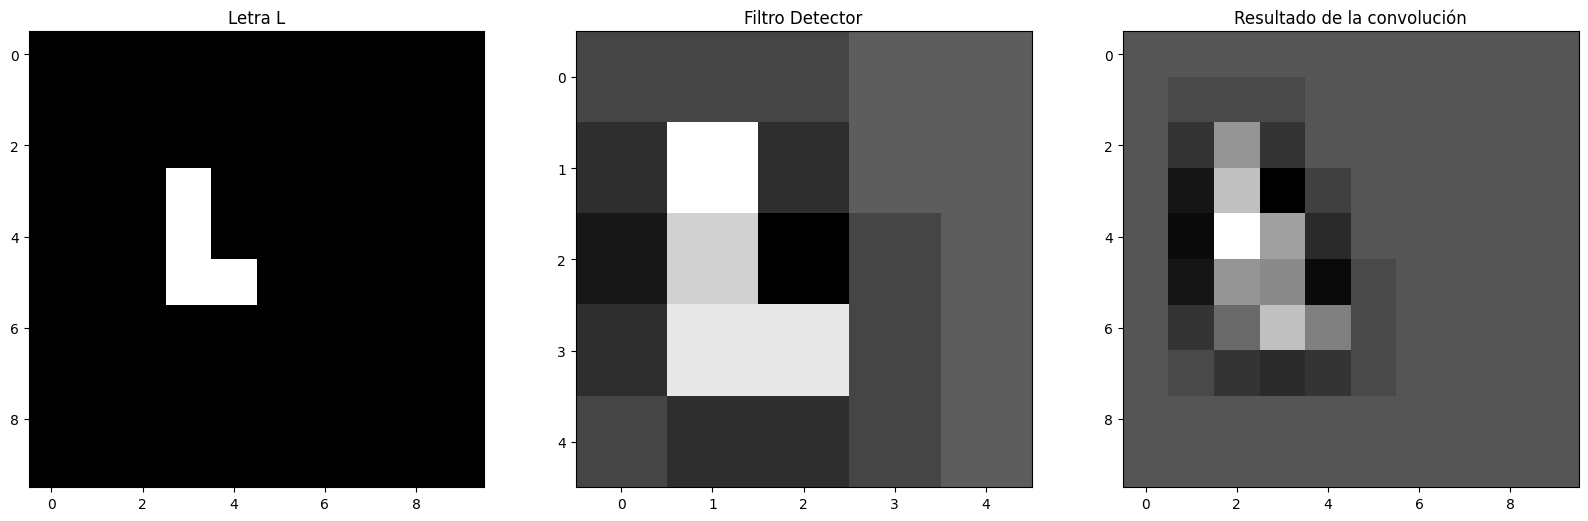

In [16]:
show_image([L_letter, filter_for_L, L_founded], ['Letra L', 'Filtro Detector', 'Resultado de la convolución'])

In [17]:
# Valores del filtro
filter_for_L

array([[-1., -1., -1.,  0.,  0.],
       [-2.,  7., -2.,  0.,  0.],
       [-3.,  5., -4., -1.,  0.],
       [-2.,  6.,  6., -1.,  0.],
       [-1., -2., -2., -1.,  0.]])

In [18]:
# Valores de la convolución
L_founded

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -3.,  6., -3.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -6., 10., -8., -2.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -7., 16.,  7., -4.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -6.,  6.,  5., -7., -1.,  0.,  0.,  0.,  0.],
       [ 0., -3.,  2., 10.,  4., -1.,  0.,  0.,  0.,  0.],
       [ 0., -1., -3., -4., -3., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

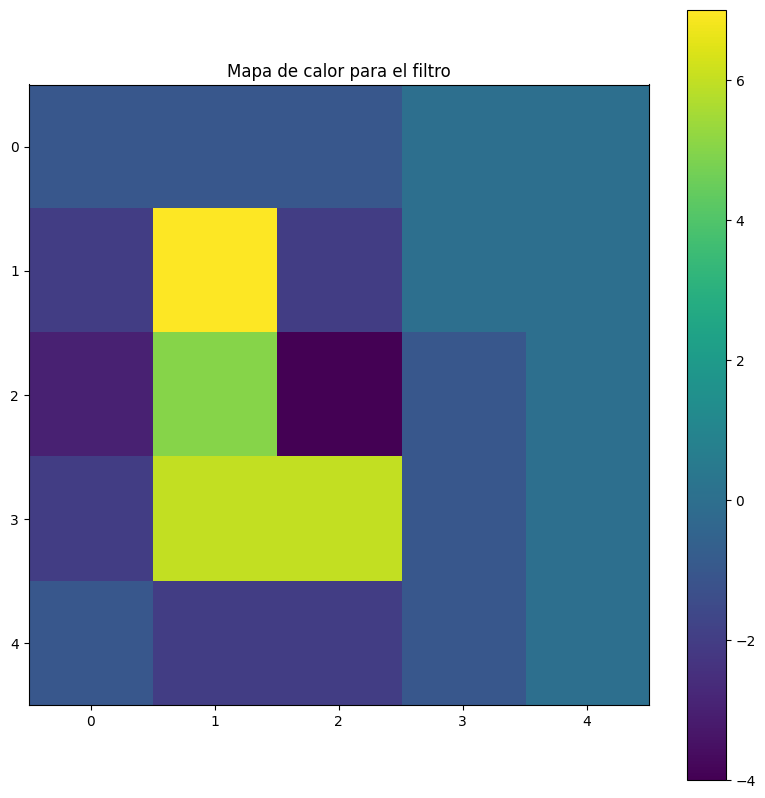

In [19]:
# Mapa de calor del filtro
plt.figure(figsize=(10, 10))
plt.imshow(filter_for_L, cmap='viridis')
plt.colorbar()
plt.title('Mapa de calor para el filtro')
plt.show()

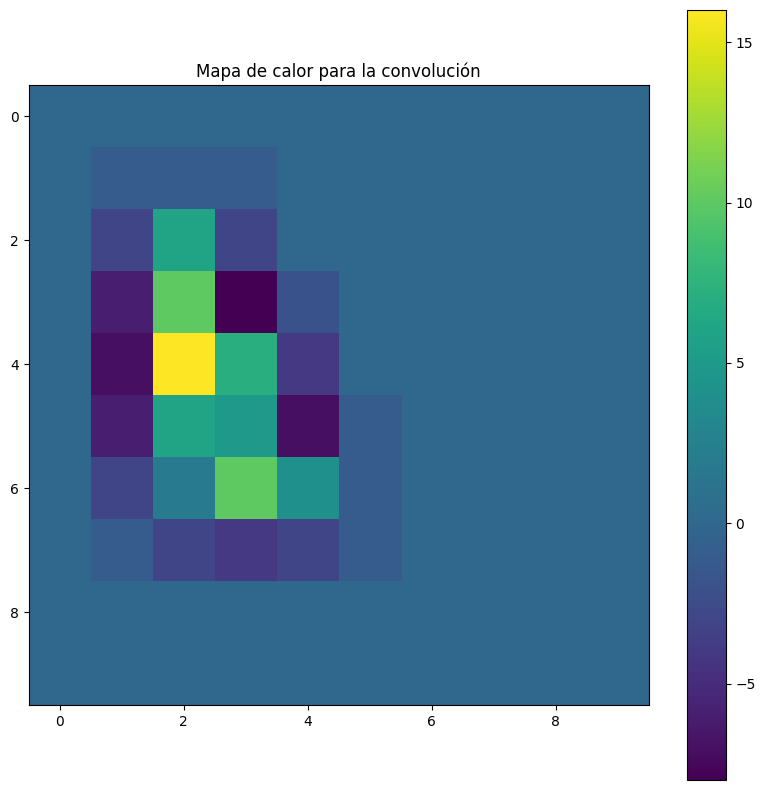

In [20]:
# Mapa de calor para la convolución
plt.figure(figsize=(10, 10))
plt.imshow(L_founded, cmap='viridis')
plt.colorbar()
plt.title('Mapa de calor para la convolución')
plt.show()

# Detección de Patrones Complejos

In [178]:
# Carga de imagen
six_diamond = cv2.imread('Imagenes/seis.jpg')
six_diamond_gray = cv2.cvtColor(six_diamond, cv2.COLOR_BGR2GRAY)

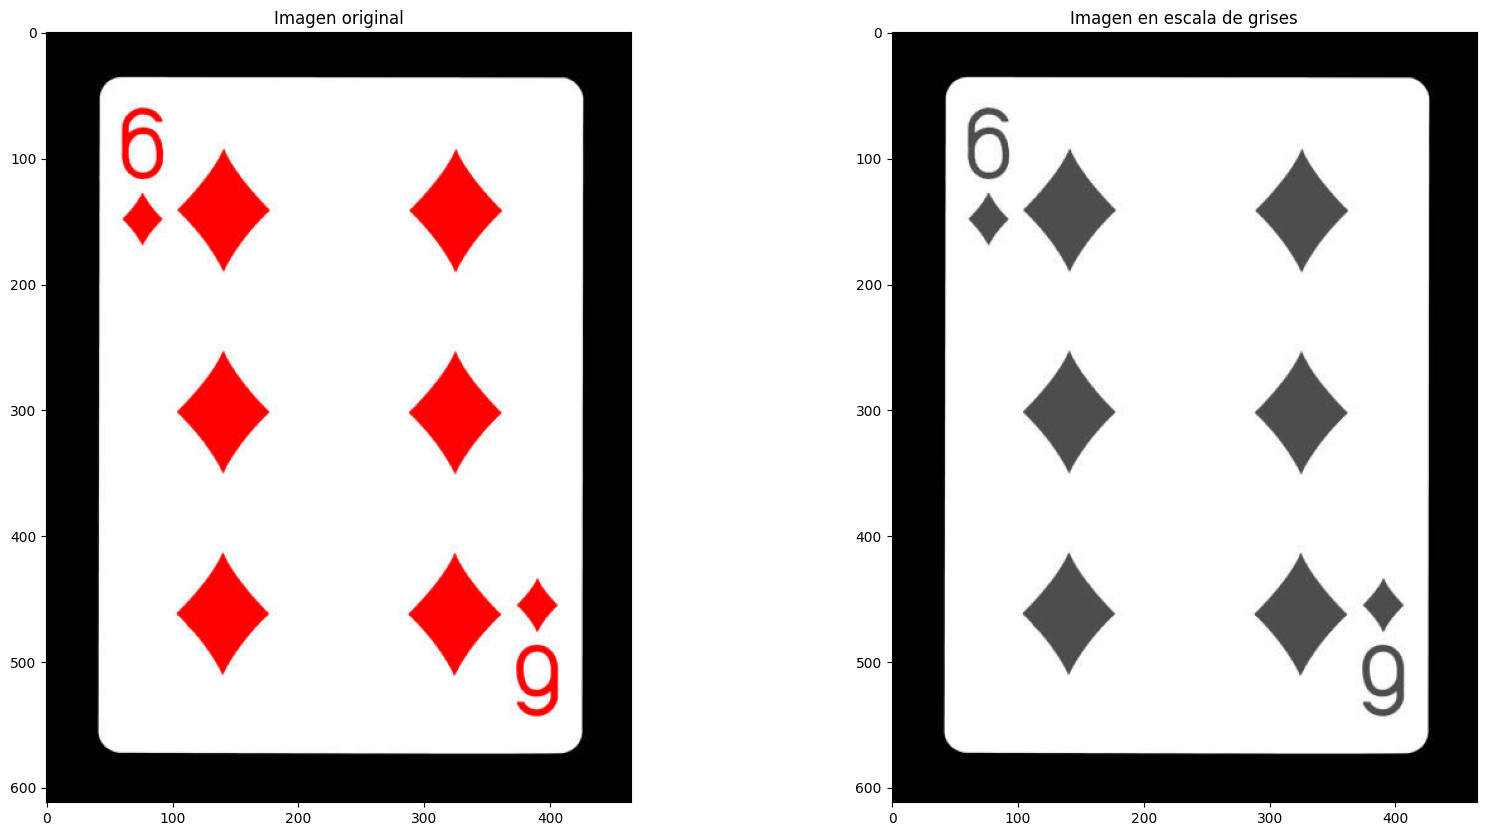

In [179]:
show_image([cv2.cvtColor(six_diamond, cv2.COLOR_BGR2RGB), six_diamond_gray], ['Imagen original', 'Imagen en escala de grises'])

## Lectura de imágenes


In [180]:
# Binarización de imágenes
seis_bin = cv2.threshold(six_diamond_gray, 128 ,255, cv2.THRESH_BINARY)[1]

# Binarización invertida
seis_bin_inv = cv2.bitwise_not(seis_bin)

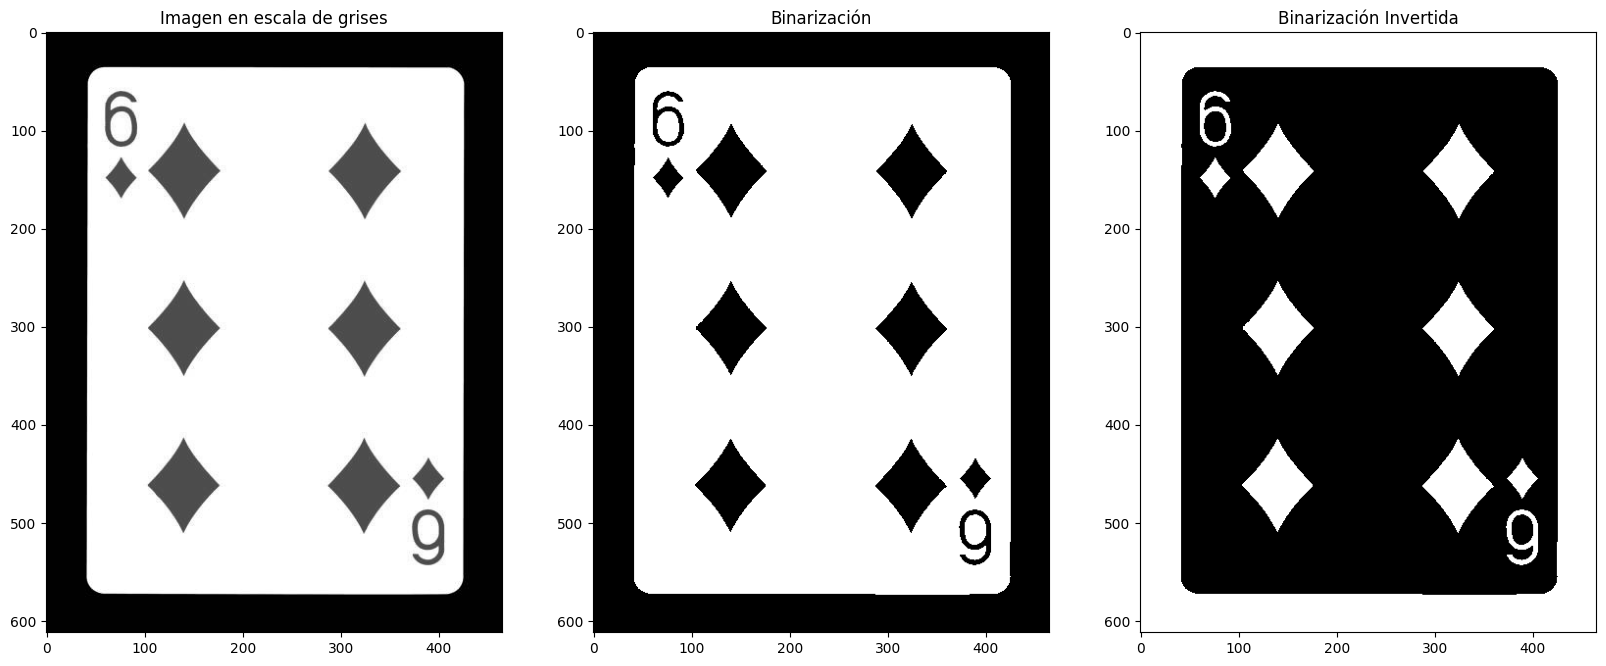

In [181]:
show_image([six_diamond_gray, seis_bin, seis_bin_inv], ['Imagen en escala de grises', 'Binarización', 'Binarización Invertida'])

## Definición de Patrón

In [182]:
# Haremos las detecciones de los patrones que queremos buscar en las imágenes
selector_diamante = ROISelector(seis_bin_inv)
roi_diamante = selector_diamante.run()

ROI seleccionada, devolviendo el array.


## Creación del Filtro Detector

In [183]:
# Usamos la función de convolución para obtener el filtro
filter_for_diamond = filter_for_image(roi_diamante, kernel, type_of_filter = 'square_cropping')

## Detección del Patrón

In [184]:
# Usamos la misma función de convolución para detectar el patrón en la imagen usando el filtro recién creado
initial_detection_diamond = convolution(seis_bin, filter_for_diamond)

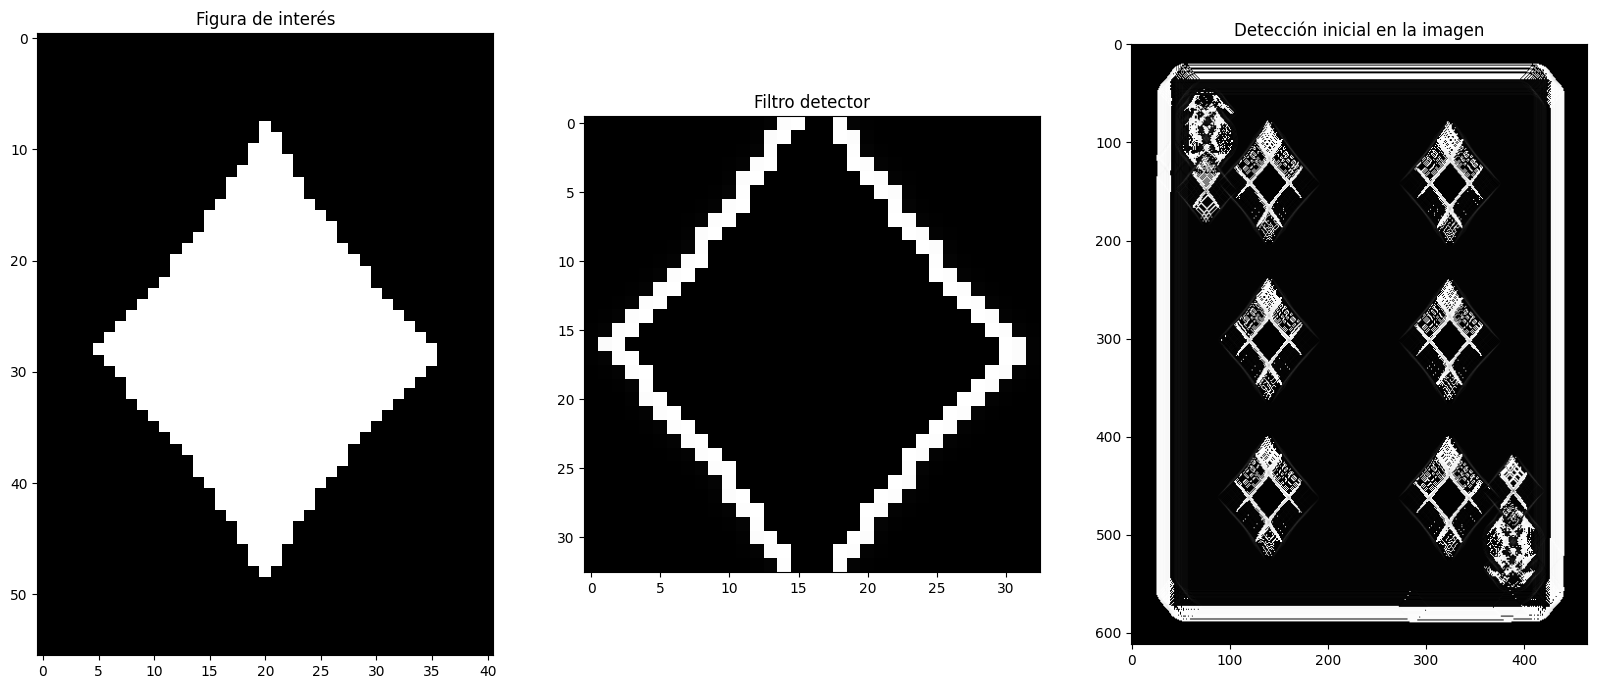

In [185]:

show_image([roi_diamante, filter_for_diamond, initial_detection_diamond], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

## Determinación del Umbral

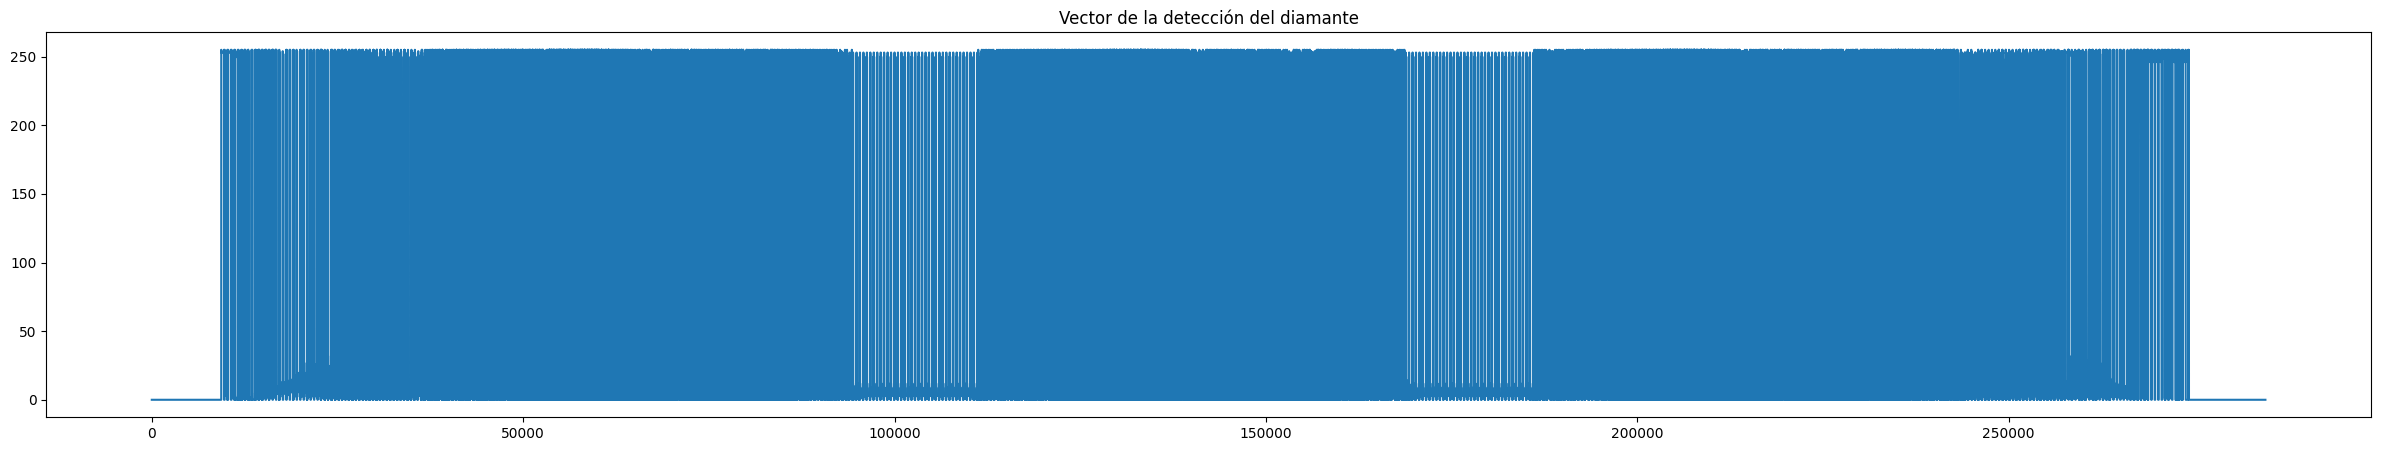

In [186]:
# Convertir matriz resultante a vector fila
diamond = initial_detection_diamond.flatten()

# Mostrar el vector en un gráfico
plt.figure(figsize=(30, 5))
plt.plot(diamond)
plt.title('Vector de la detección del diamante')
plt.show()

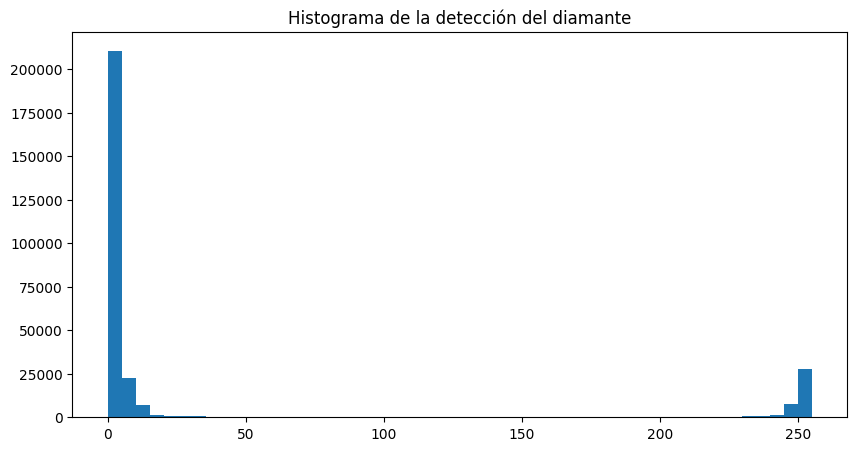

In [187]:
# Histograma
plt.figure(figsize=(10, 5))
plt.hist(diamond, bins=50)
plt.title('Histograma de la detección del diamante')
plt.show()

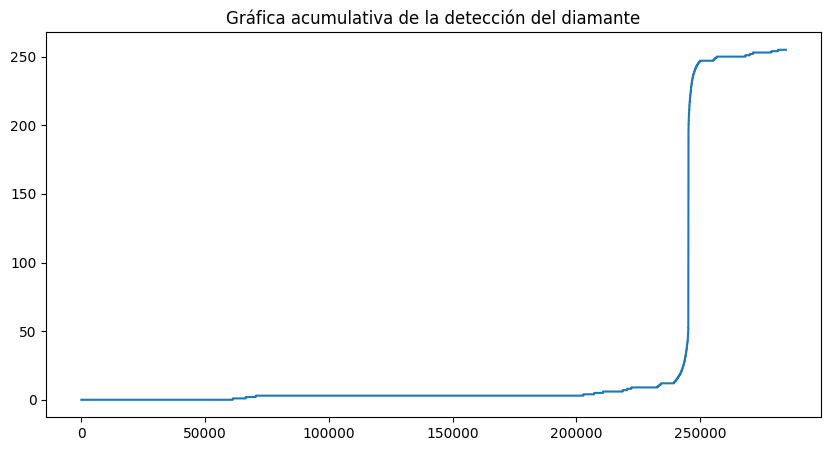

In [188]:
# Gráfica acumulativa
plt.figure(figsize=(10, 5))
plt.plot(np.sort(diamond))
plt.title('Gráfica acumulativa de la detección del diamante')
plt.show()

## Supresión de no Máximos o Non-Max Supression (NMS)

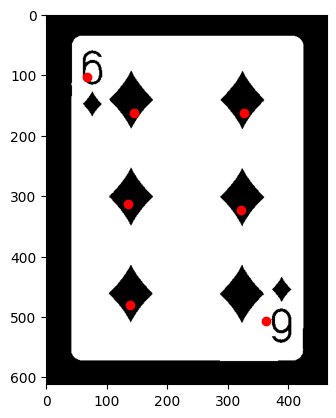

In [189]:
# Definir umbral
umbral = 200

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 4
eps = 30
min_samples = 10

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_diamond > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_diamond, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(seis_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

## Visualización de la detección

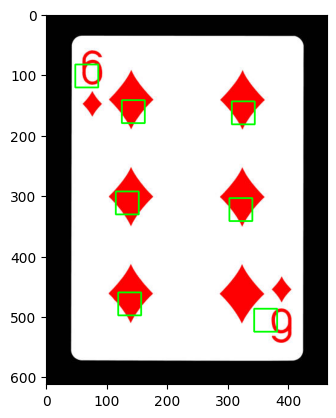

In [190]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(six_diamond, detecciones_filtradas.astype(int), filter_for_diamond.shape[1], filter_for_diamond.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))
plt.show()

# Más Patrones a Detectar

## Caballos y Peones

In [191]:
# Carga de imagen
chessBoard = cv2.imread('Imagenes/ChessBoard.jpg')
chessBoard_gray = cv2.cvtColor(chessBoard, cv2.COLOR_BGR2GRAY)

In [192]:
# Binarización de imagen e invertida
chessBoard_bin = cv2.threshold(chessBoard_gray, 128 ,255, cv2.THRESH_BINARY)[1]
chessBoard_bin_inv = cv2.bitwise_not(chessBoard_bin)

### Caballos

In [352]:
# Definición de patrón "caballo"
selector_caballo = ROISelector(chessBoard_bin_inv)
roi_caballo = selector_caballo.run()

ROI seleccionada, devolviendo el array.


In [356]:
# Creación de filtro "caballo"
filter_for_caballo = filter_for_image(roi_caballo, kernel, 'square_padding')

In [357]:
# Detección del patrón "caballo"
initial_detection_caballo = convolution(chessBoard_bin, filter_for_caballo)

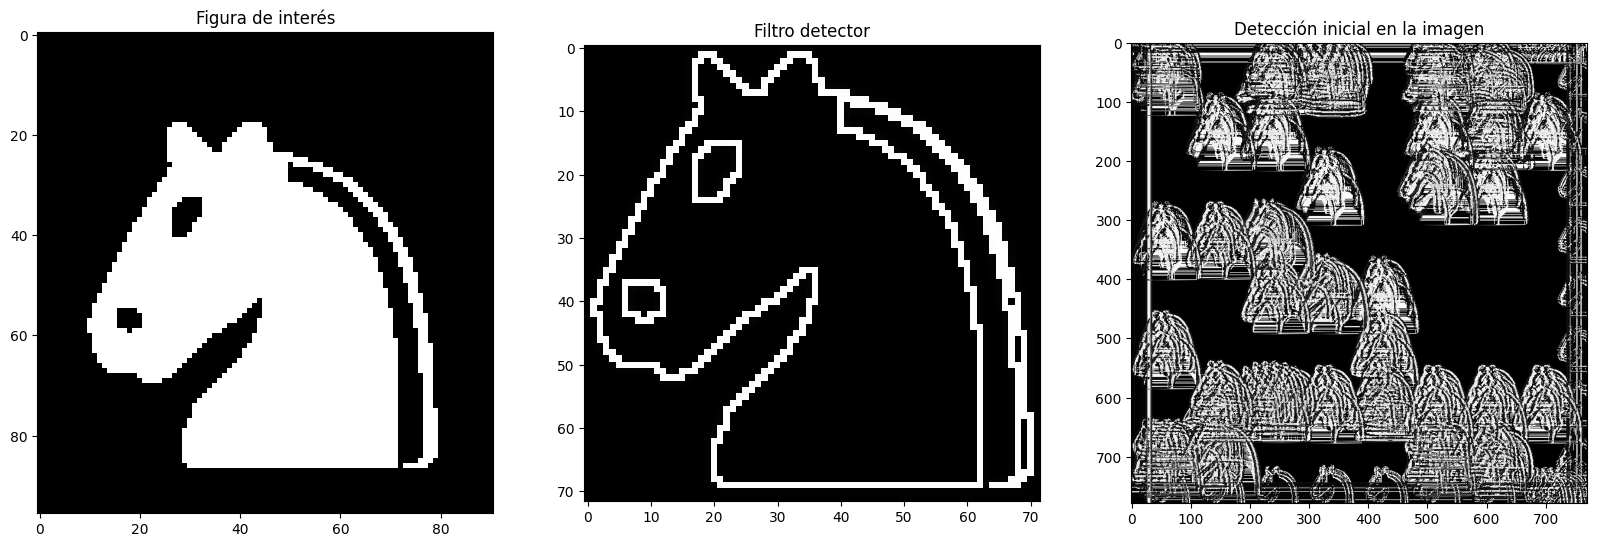

In [358]:
show_image([roi_caballo, filter_for_caballo, initial_detection_caballo], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

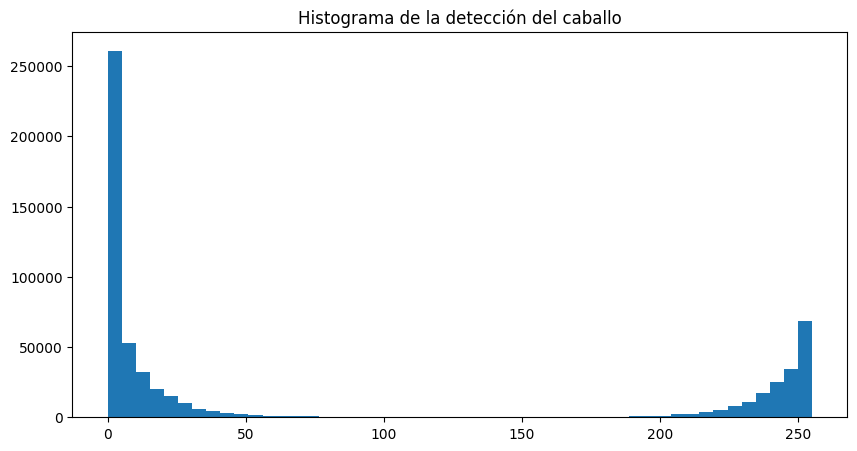

In [359]:
# Convertir matriz resultante a vector fila
caballo = initial_detection_caballo.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(caballo, bins=50)
plt.title('Histograma de la detección del caballo')
plt.show()

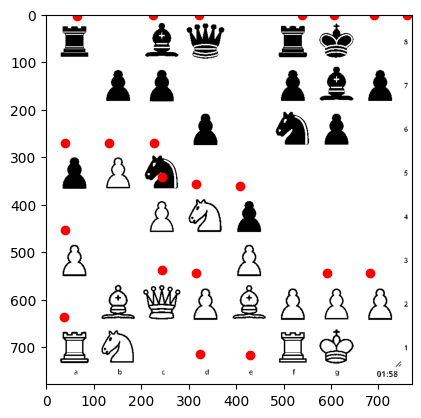

In [410]:
# Definir umbral
umbral = 220

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 25
eps = 50
min_samples = 1

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_caballo > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_caballo, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(chessBoard_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

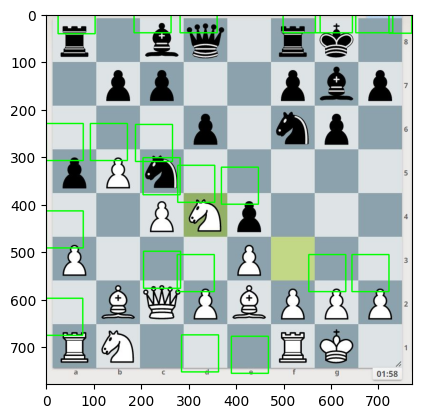

In [369]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(chessBoard, detecciones_filtradas.astype(int), filter_for_caballo.shape[1], filter_for_caballo.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

### Peones

In [370]:
# Definición de patrón "peón"
selector_peon = ROISelector(chessBoard_bin_inv)
roi_peon = selector_peon.run()

ROI seleccionada, devolviendo el array.


In [371]:
# Creación de filtro "peón"
filter_for_peon = filter_for_image(roi_peon, kernel, 'square_cropping')

In [372]:
# Detección del patrón "peón"
initial_detection_peon = convolution(chessBoard_bin, filter_for_peon)

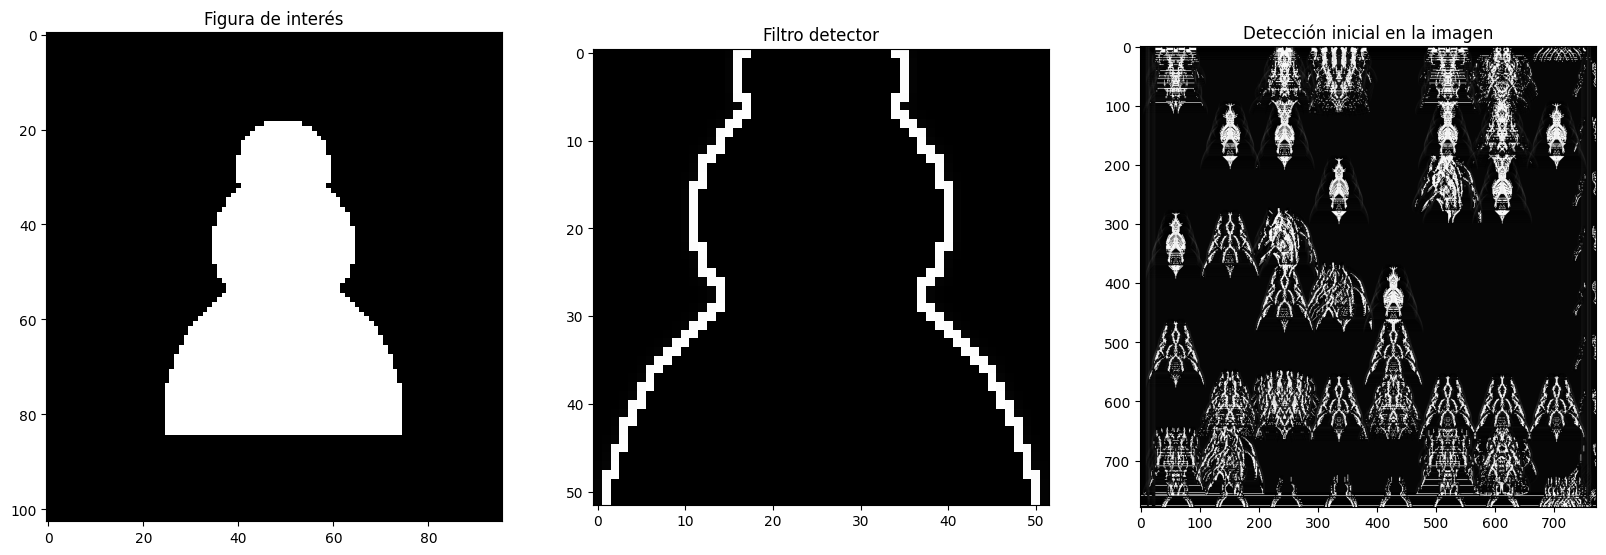

In [373]:
show_image([roi_peon, filter_for_peon, initial_detection_peon], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

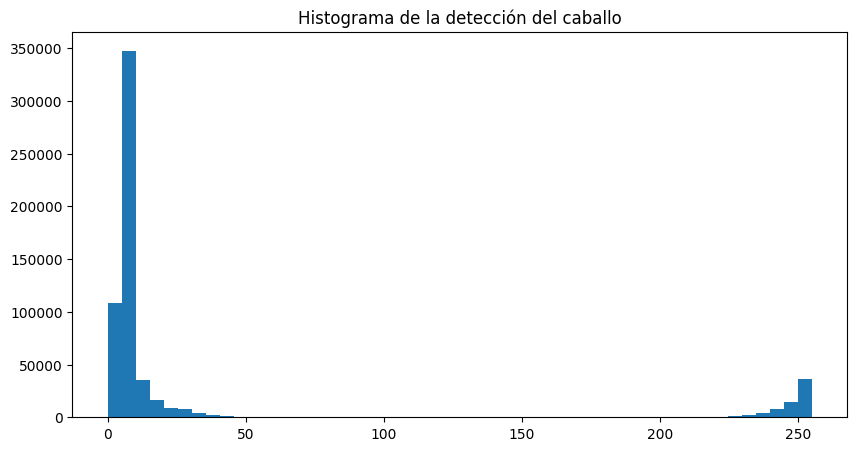

In [374]:
# Convertir matriz resultante a vector fila
peon = initial_detection_peon.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(peon, bins=50)
plt.title('Histograma de la detección del caballo')
plt.show()

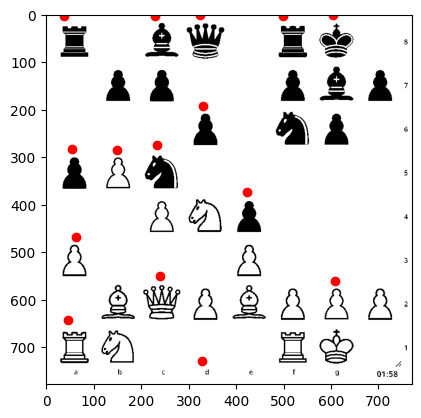

In [408]:
# Definir umbral
umbral = 200

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 60
eps = 40
min_samples = 1

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_peon > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_peon, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(chessBoard_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

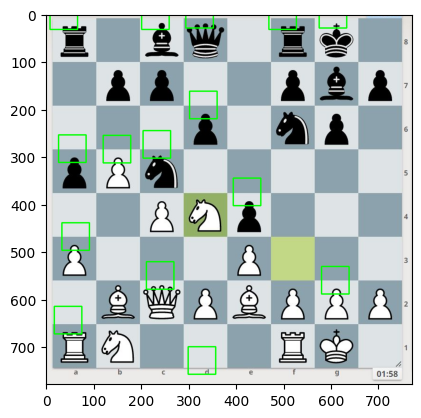

In [402]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(chessBoard, detecciones_filtradas.astype(int), filter_for_peon.shape[1], filter_for_peon.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

## Palabras "CAT" y "DOG"

In [4]:
# Carga de imagen
sopaLetras = cv2.imread('Imagenes/SopaLetras.jpg')
sopaLetras_gray = cv2.cvtColor(sopaLetras, cv2.COLOR_BGR2GRAY)

In [5]:
# Binarización de imagen e invertida
sopaLetras_bin = cv2.threshold(sopaLetras_gray, 128 ,255, cv2.THRESH_BINARY)[1]
sopaLetras_bin_inv = cv2.bitwise_not(sopaLetras_bin)

### CAT

In [413]:
# Definición de patrón "CAT"
selector_cat = ROISelector(sopaLetras_bin_inv)
roi_cat = selector_cat.run()

ROI seleccionada, devolviendo el array.


In [429]:
# Creación de filtro "CAT"
filter_for_cat = filter_for_image(roi_cat, kernel, type_of_filter = 'None', delete_all_zeros = False, delete_border_zeros = True)

In [430]:
# Detección del patrón "CAT"
initial_detection_cat = convolution(sopaLetras_bin, filter_for_cat)

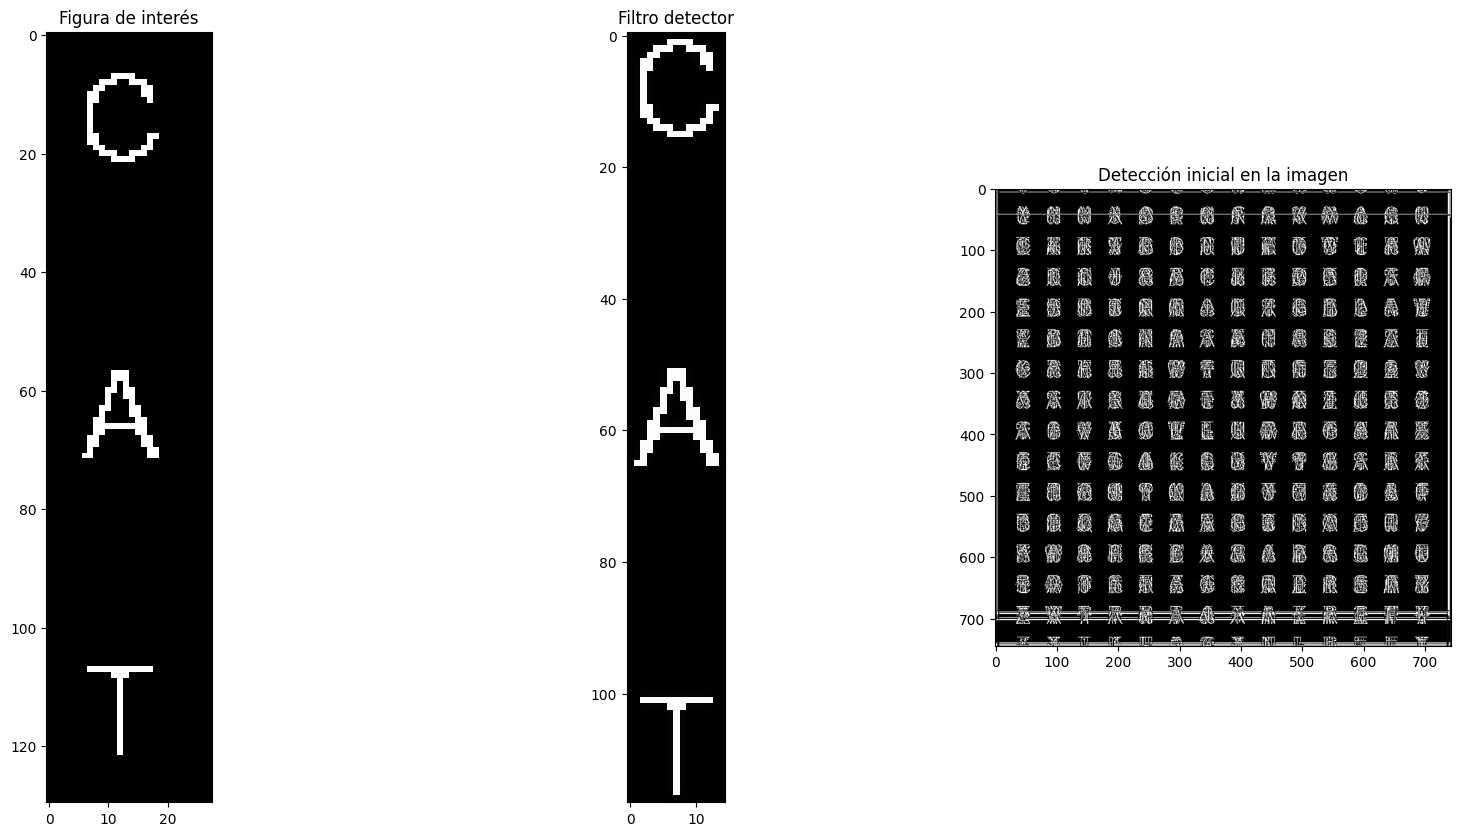

In [431]:
show_image([roi_cat, filter_for_cat, initial_detection_cat], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

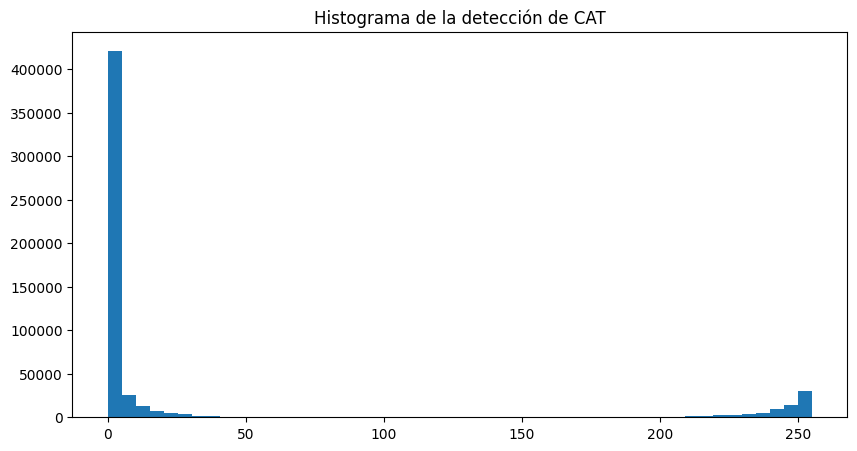

In [432]:
# Convertir matriz resultante a vector fila
cat = initial_detection_cat.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(cat, bins=50)
plt.title('Histograma de la detección de CAT')
plt.show()

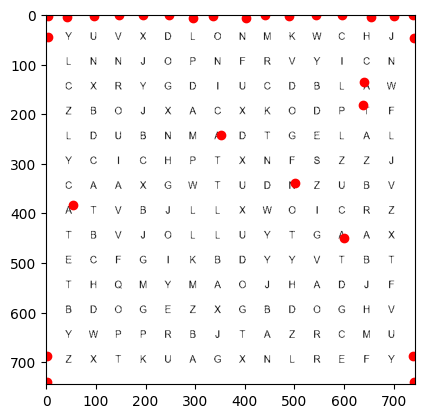

In [433]:
# Definir umbral
umbral = 250

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 30
eps = 10
min_samples = 1

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_cat > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_cat, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(sopaLetras_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

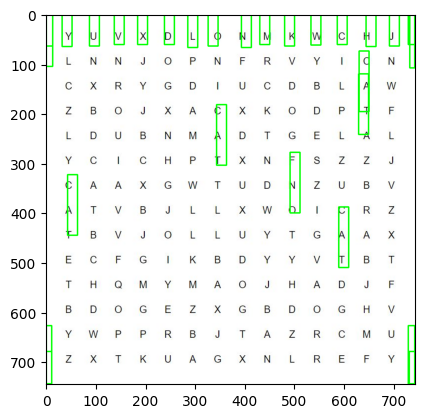

In [434]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(sopaLetras, detecciones_filtradas.astype(int), filter_for_cat.shape[1], filter_for_cat.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

### DOG

In [6]:
# Definición de patrón "DOG"
selector_dog = ROISelector(sopaLetras_bin_inv)
roi_dog = selector_dog.run()

ROI seleccionada, devolviendo el array.


In [14]:
# Creación de filtro "DOG"
filter_for_dog = filter_for_image(roi_dog, kernel, type_of_filter = None, delete_all_zeros = False, delete_border_zeros = True)

In [15]:
# Detección del patrón "DOG"
initial_detection_dog = convolution(sopaLetras_bin, filter_for_dog)

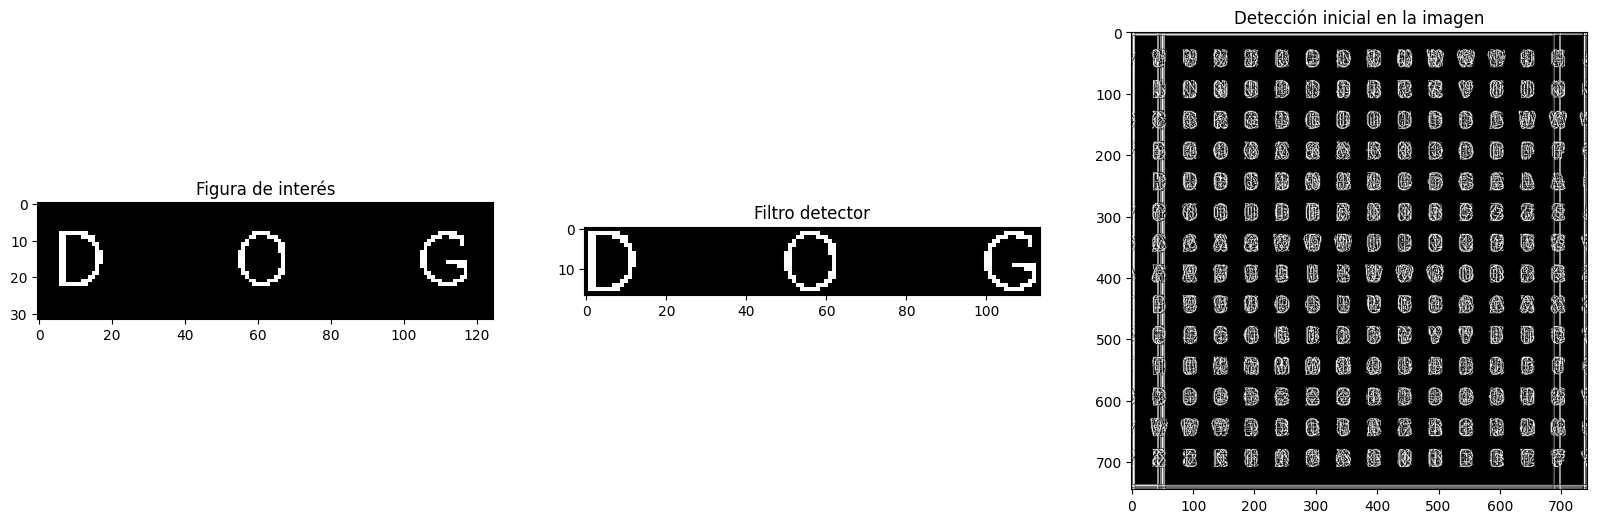

In [16]:
show_image([roi_dog, filter_for_dog, initial_detection_dog], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

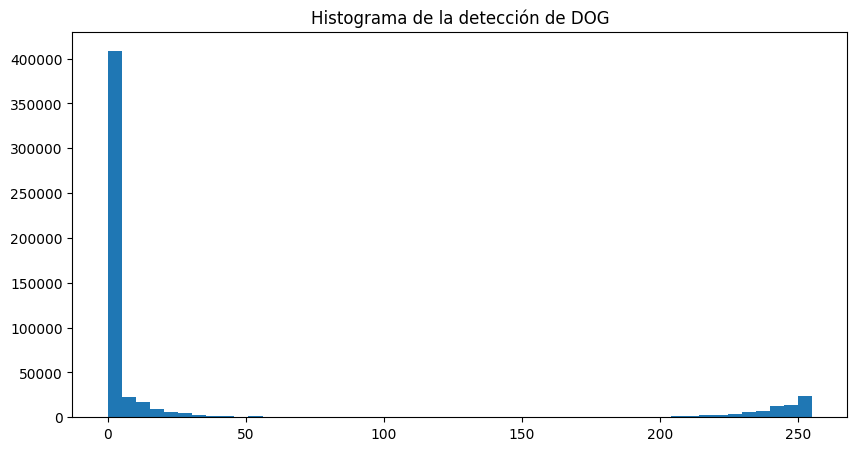

In [18]:
# Convertir matriz resultante a vector fila
dog = initial_detection_dog.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(dog, bins=50)
plt.title('Histograma de la detección de DOG')
plt.show()

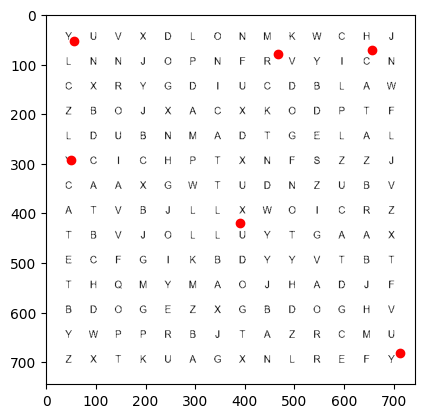

In [44]:
# Definir umbral
umbral = 250

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 10
eps = 50
min_samples = 5

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_dog > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_dog, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(sopaLetras_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

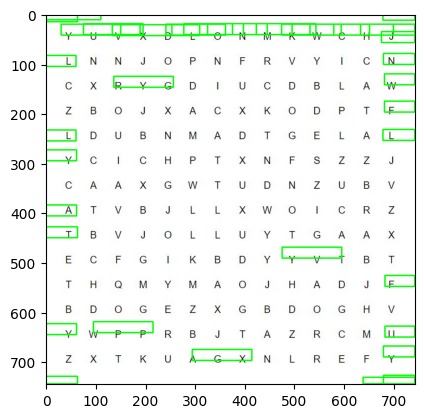

In [445]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(sopaLetras, detecciones_filtradas.astype(int), filter_for_dog.shape[1], filter_for_dog.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

## Diamantes

In [45]:
# Carga de imagen
cartas = cv2.imread('Imagenes/cartas.jpg')
seis = cv2.imread('Imagenes/seis.jpg')
cartas_gray = cv2.cvtColor(cartas, cv2.COLOR_BGR2GRAY)
seis_gray = cv2.cvtColor(seis, cv2.COLOR_BGR2GRAY)

In [46]:
# Binarización de imagen e invertida
cartas_bin = cv2.threshold(cartas_gray, 128 ,255, cv2.THRESH_BINARY)[1]
seis_bin = cv2.threshold(seis_gray, 128 ,255, cv2.THRESH_BINARY)[1]
cartas_bin_inv = cv2.bitwise_not(cartas_bin)
seis_bin_inv = cv2.bitwise_not(seis_bin)

### Filtro de "seis.jpg"

In [47]:
# Definición de patrón "diamante_seis"
selector_diamante = ROISelector(seis_bin_inv)
roi_diamante = selector_diamante.run()

ROI seleccionada, devolviendo el array.


In [48]:
# Creación de filtro "diamante"
filter_for_diamante = filter_for_image(roi_diamante, kernel, type_of_filter = 'square_cropping')

#### Detección en "seis.jpg"

In [49]:
# Detección del patrón "diamante" en "seis.jpg"
initial_detection_diamante = convolution(seis_bin, filter_for_diamante)

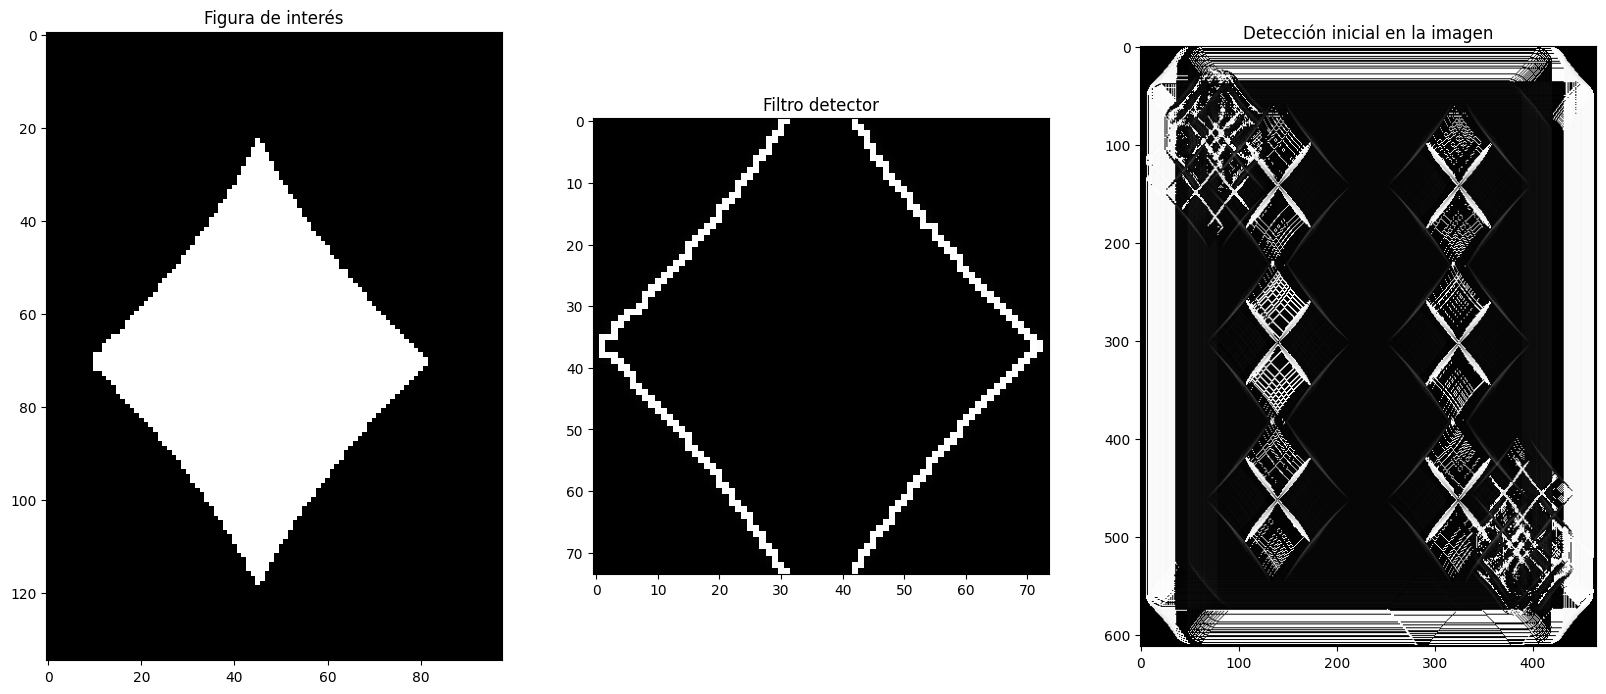

In [50]:
show_image([roi_diamante, filter_for_diamante, initial_detection_diamante], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

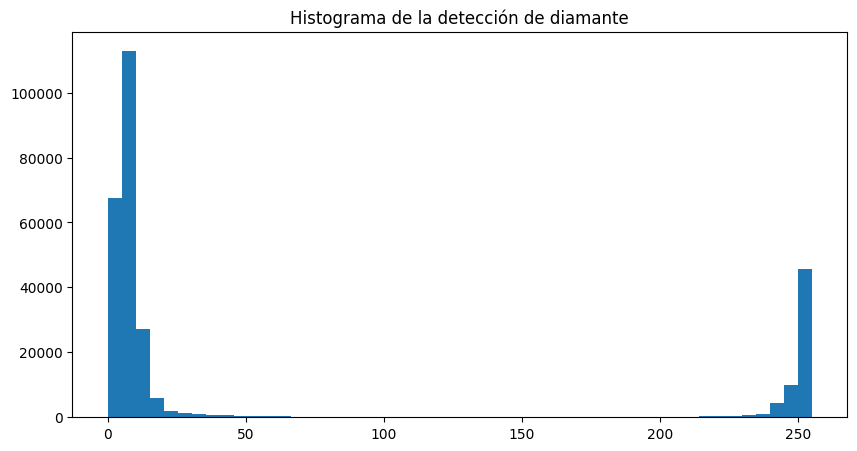

In [51]:
# Convertir matriz resultante a vector fila
diamante = initial_detection_diamante.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(diamante, bins=50)
plt.title('Histograma de la detección de diamante')
plt.show()

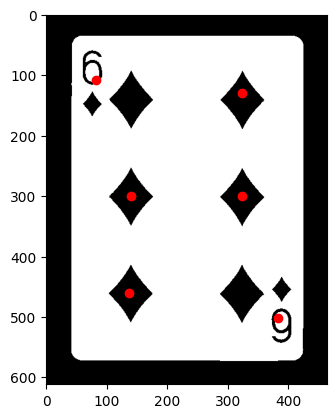

In [52]:
# Definir umbral
umbral = 200

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 4
eps = 38
min_samples = 10

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_diamante > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_diamante, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(seis_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

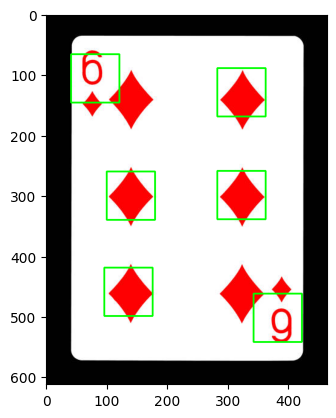

In [53]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(seis, detecciones_filtradas.astype(int), filter_for_diamante.shape[1], filter_for_diamante.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

#### Detección en "cartas.jpg"

In [54]:
# Detección del patrón "diamante" en "cartas.jpg"
initial_detection_diamante = convolution(cartas_bin, filter_for_diamante)

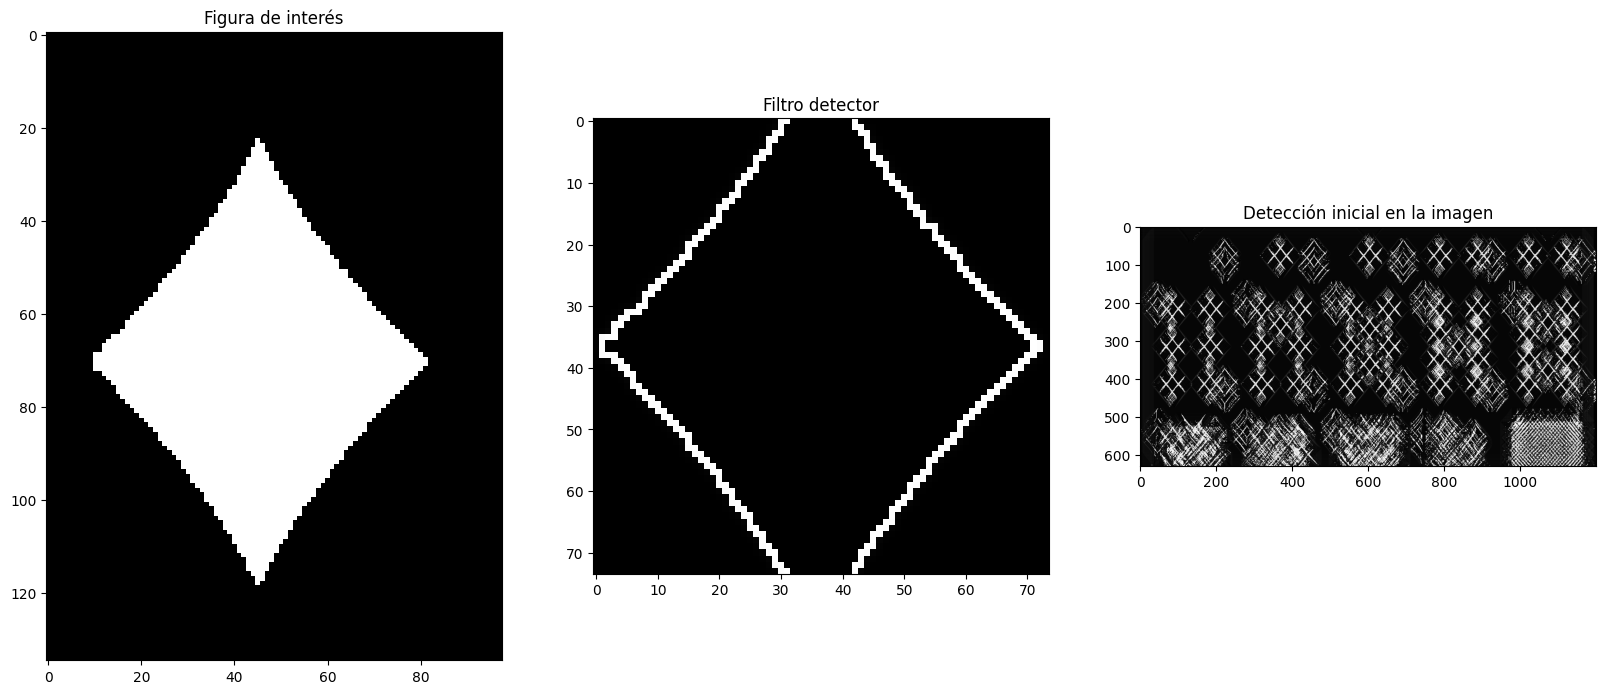

In [55]:
show_image([roi_diamante, filter_for_diamante, initial_detection_diamante], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

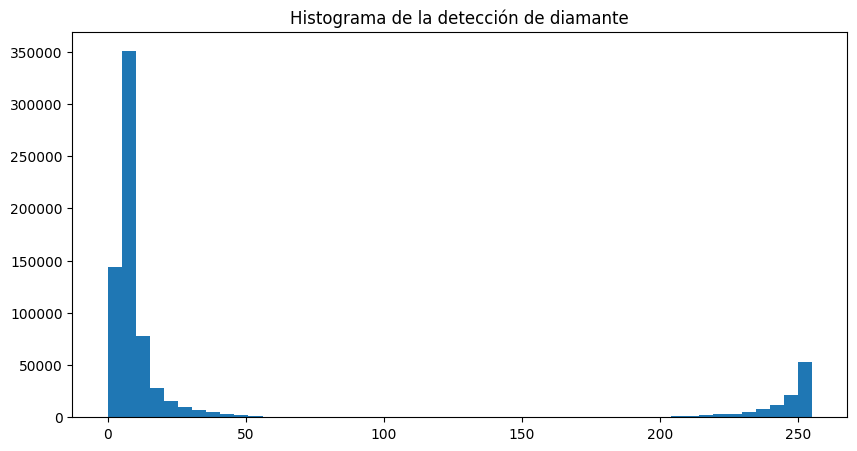

In [56]:
# Convertir matriz resultante a vector fila
diamante = initial_detection_diamante.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(diamante, bins=50)
plt.title('Histograma de la detección de diamante')
plt.show()

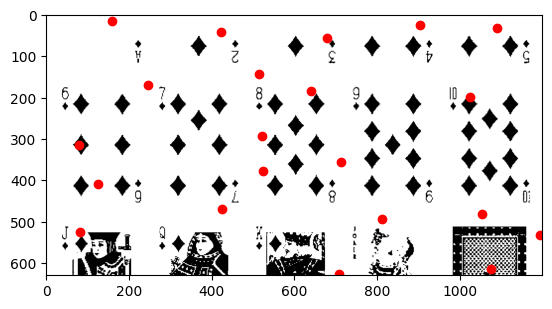

In [71]:
# Definir umbral
umbral = 200

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 15
eps = 80
min_samples = 1

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_diamante > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_diamante, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(cartas_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

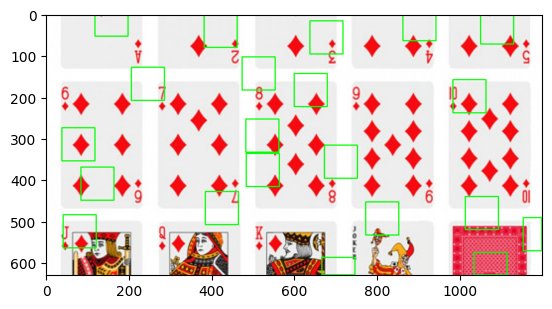

In [72]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(cartas, detecciones_filtradas.astype(int), filter_for_diamante.shape[1], filter_for_diamante.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

### Filtro de "cartas.jpg"

In [73]:
# Definición de patrón "diamante_cartas"
selector_diamante = ROISelector(cartas_bin_inv)
roi_diamante = selector_diamante.run()

ROI seleccionada, devolviendo el array.


In [74]:
# Creación de filtro "diamante_cartas"
filter_for_diamante = filter_for_image(roi_diamante, kernel, type_of_filter = 'square_cropping')

#### Detección en "seis.jpg"

In [75]:
# Detección del patrón "diamante" en "seis.jpg"
initial_detection_diamante = convolution(seis_bin, filter_for_diamante)

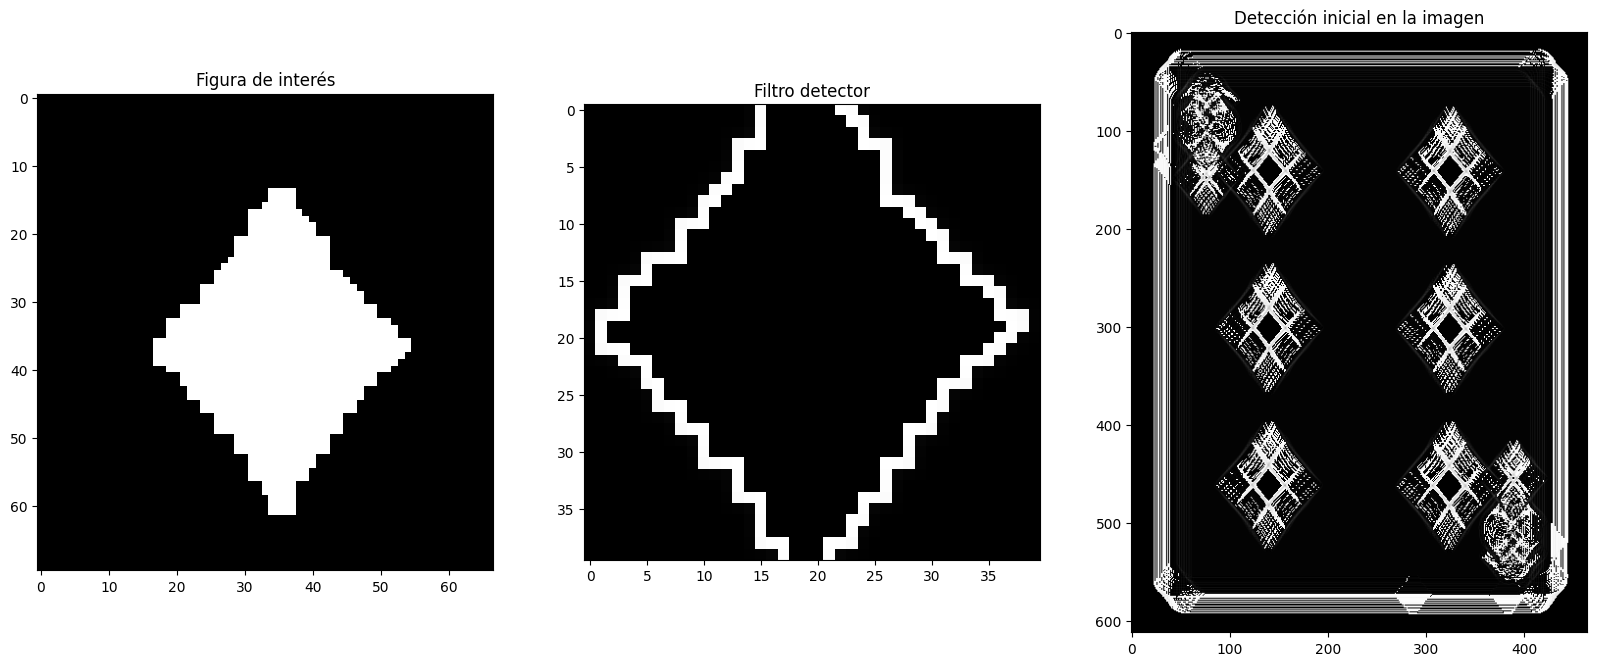

In [76]:
show_image([roi_diamante, filter_for_diamante, initial_detection_diamante], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

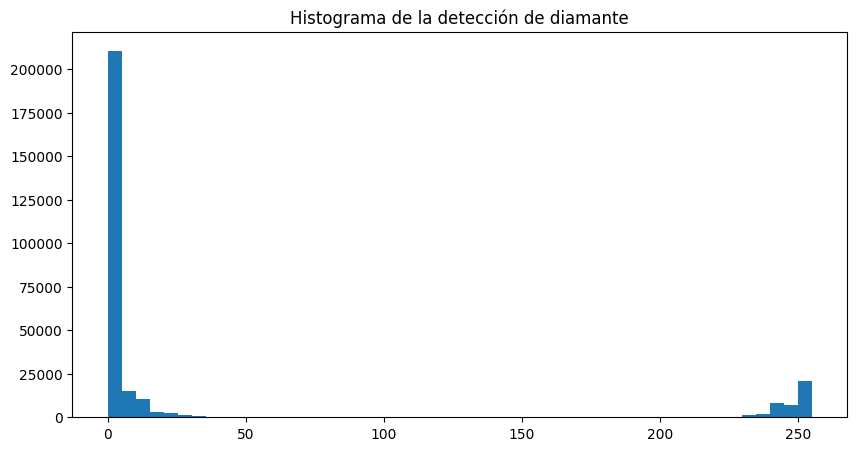

In [77]:
# Convertir matriz resultante a vector fila
diamante = initial_detection_diamante.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(diamante, bins=50)
plt.title('Histograma de la detección de diamante')
plt.show()

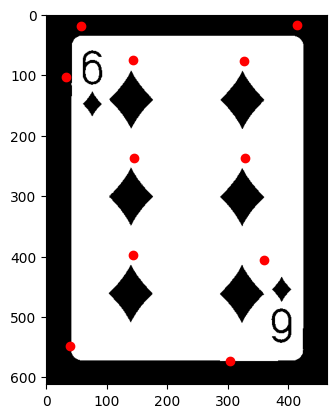

In [80]:
# Definir umbral
umbral = 200

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 15
eps = 80
min_samples = 1

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_diamante > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_diamante, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(seis_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

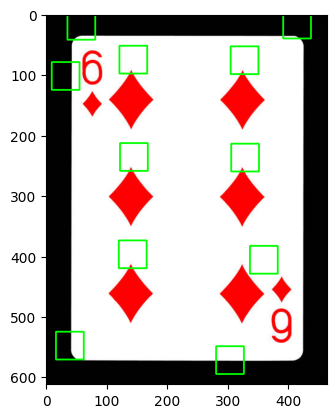

In [81]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(seis, detecciones_filtradas.astype(int), filter_for_diamante.shape[1], filter_for_diamante.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

#### Detección en "cartas.jpg"

In [82]:
# Detección del patrón "diamante" en "cartas.jpg"
initial_detection_diamante = convolution(cartas_bin, filter_for_diamante)

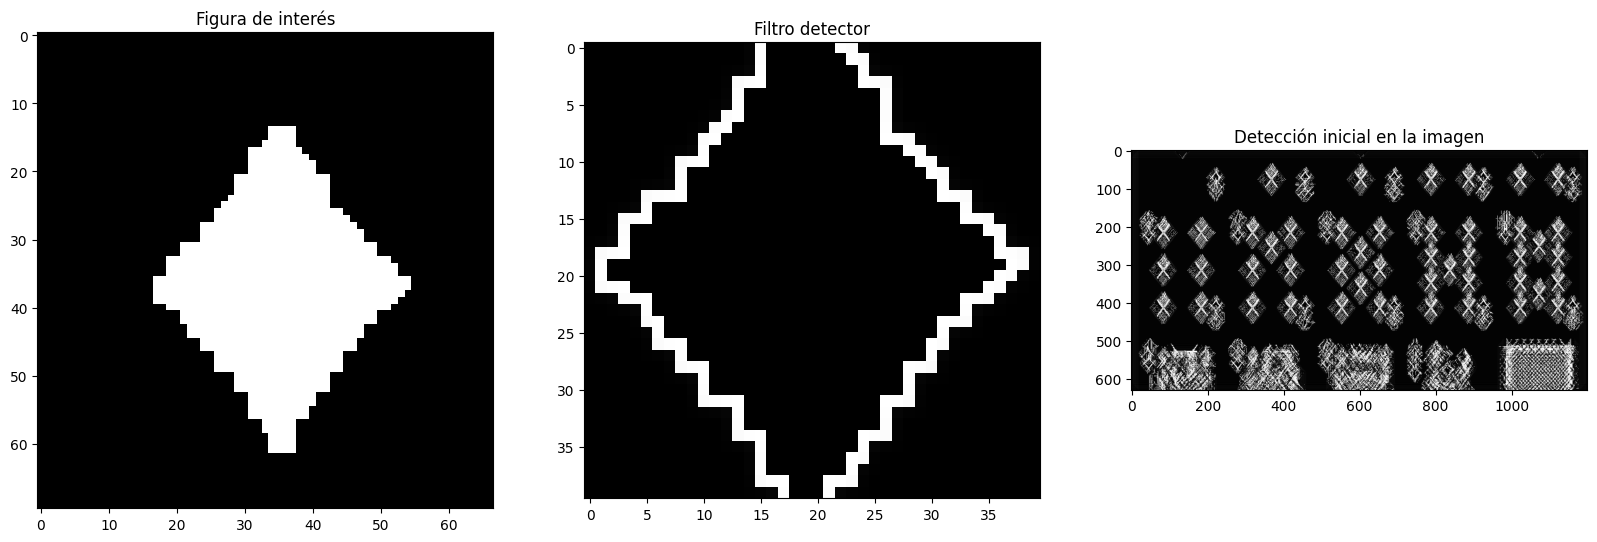

In [83]:
show_image([roi_diamante, filter_for_diamante, initial_detection_diamante], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

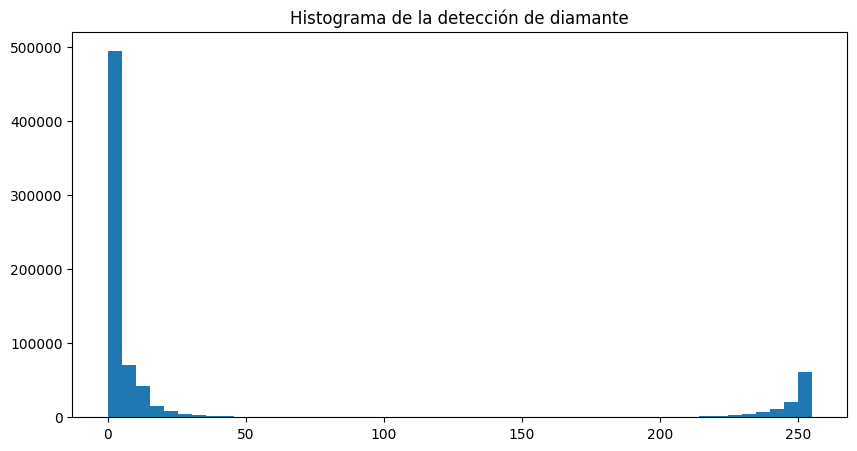

In [84]:
# Convertir matriz resultante a vector fila
diamante = initial_detection_diamante.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(diamante, bins=50)
plt.title('Histograma de la detección de diamante')
plt.show()

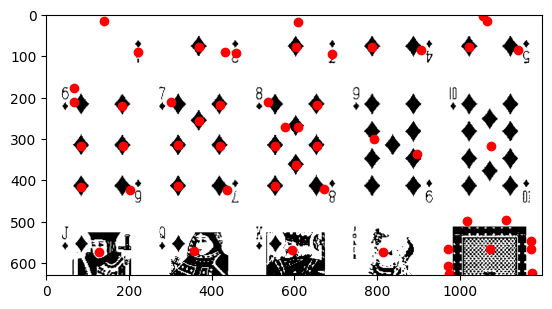

In [85]:
# Definir umbral
umbral = 180

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 1
eps = 5
min_samples = 4

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_diamante > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_diamante, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(cartas_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

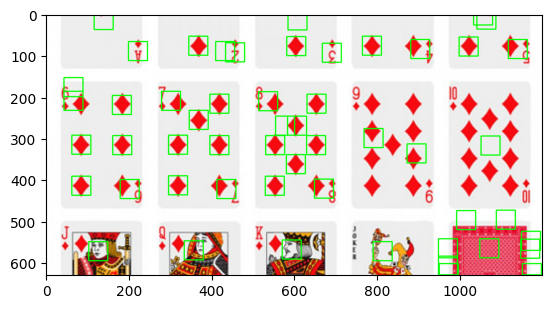

In [86]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(cartas, detecciones_filtradas.astype(int), filter_for_diamante.shape[1], filter_for_diamante.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))

## Palabra "no"

In [21]:
# Carga de imagen
mancha = cv2.imread('Imagenes/mancha.jpg')
mancha_gray = cv2.cvtColor(mancha, cv2.COLOR_BGR2GRAY)

In [22]:
# Binarización de imagen e invertida
mancha_bin = cv2.threshold(mancha_gray, 128 ,255, cv2.THRESH_BINARY)[1]
mancha_bin_inv = cv2.bitwise_not(mancha_bin)

In [23]:
# Definición de patrón "no"
selector_no = ROISelector(mancha_bin_inv)
roi_no = selector_no.run()

ROI seleccionada, devolviendo el array.


In [24]:
# Creación de filtro "no"
filter_for_no = filter_for_image(roi_no, kernel, 'square_cropping', delete_all_zeros = False, delete_border_zeros = True)

In [25]:
# Detección del patrón "diamante" en "seis.jpg"
initial_detection_no = convolution(mancha_bin, filter_for_no)

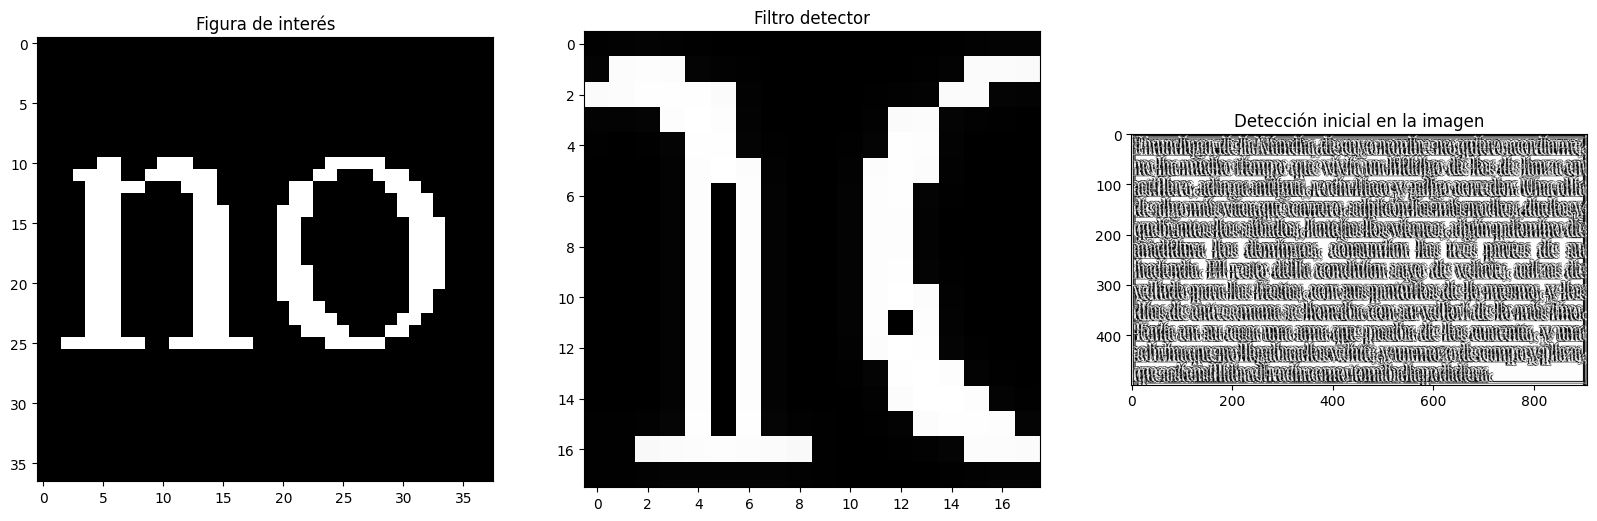

In [26]:
show_image([roi_no, filter_for_no, initial_detection_no], ['Figura de interés', 'Filtro detector', 'Detección inicial en la imagen'])

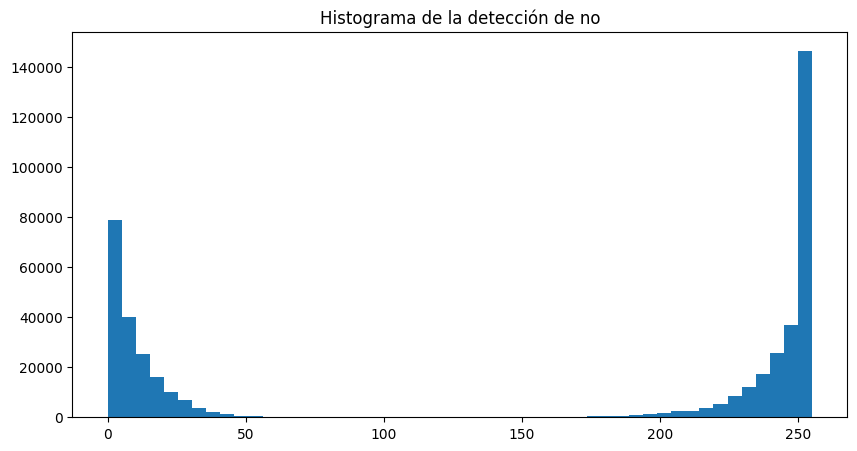

In [27]:
# Convertir matriz resultante a vector fila
no = initial_detection_no.flatten()

# Histograma
plt.figure(figsize=(10, 5))
plt.hist(no, bins=50)
plt.title('Histograma de la detección de no')
plt.show()

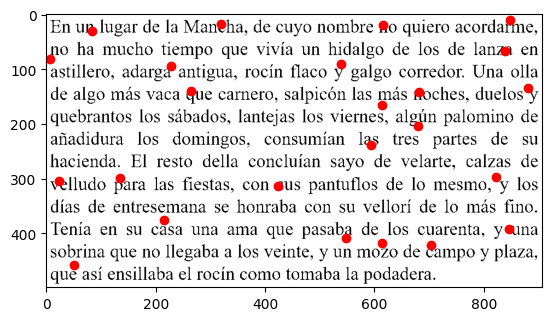

In [36]:
# Definir umbral
umbral = 250

# Parámetros del algoritmo NMS y DBSCAN
vecindad = 10
eps = 30
min_samples = 3

# Obtener las coordenadas donde las activaciones superan el umbral
puntos_sobre_umbral = np.argwhere(initial_detection_no > umbral)

# Aplicar Non-Max Suppression y DBSCAN para obtner los centros de las figuras detectadas
detecciones_filtradas = non_max_suppression(puntos_sobre_umbral, initial_detection_no, vecindad = vecindad, eps = eps, min_samples = min_samples)[1]

# Visualizar las detecciones filtradas
plt.imshow(mancha_bin, cmap='gray')
for (y, x) in detecciones_filtradas:
    plt.plot(y, x, 'ro')  # Marcar los puntos detectados con un círculo rojo
plt.show()

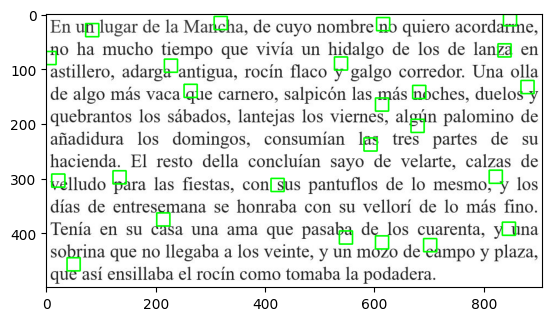

In [37]:
# Dibujar bounding boxes
image_with_grouped_boxes = draw_fixed_size_bounding_boxes(mancha, detecciones_filtradas.astype(int), filter_for_no.shape[1], filter_for_no.shape[0])

# Mostrar la imagen con las bounding boxes agrupadas
plt.imshow(cv2.cvtColor(image_with_grouped_boxes, cv2.COLOR_BGR2RGB))